In [ ]:
import pyspark
from pyspark.sql import SparkSession
import seaborn as sns
import pandas as pd


# Initialize Spark session
spark = SparkSession.builder \
    .appName("MyApp") \
    .getOrCreate()

# Read CSV file into DataFrame
df = spark.read.csv("./originalDataSets/ecommerce_customer_data_large.csv", header=True, inferSchema=True)

# Show the DataFrame
df.show()

# Check for null values in the DataFrame
null_counts = df.select([pyspark.sql.functions.count(pyspark.sql.functions.when(pyspark.sql.functions.col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

# Replace null values in the 'Returns' column with 0
df = df.fillna({'Returns': 0})

# Show the updated DataFrame
df.show()

# Check for null values in the DataFrame
null_counts = df.select([pyspark.sql.functions.count(pyspark.sql.functions.when(pyspark.sql.functions.col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+-----------+-------------------+----------------+-------------+--------+---------------------+--------------+------------+-------+--------------+---+------+-----+
|Customer ID|      Purchase Date|Product Category|Product Price|Quantity|Total Purchase Amount|Payment Method|Customer Age|Returns| Customer Name|Age|Gender|Churn|
+-----------+-------------------+----------------+-------------+--------+---------------------+--------------+------------+-------+--------------+---+------+-----+
|      44605|2023-05-03 21:30:02|            Home|          177|       1|                 2427|        PayPal|          31|    1.0|   John Rivera| 31|Female|    0|
|      44605|2021-05-16 13:57:44|     Electronics|          174|       3|                 2448|        PayPal|          31|    1.0|   John Rivera| 31|Female|    0|
|      44605|2020-07-13 06:16:57|           Books|          413|       1|                 2345|   Credit Card|          31|    1.0|   John Rivera| 31|Female|    0|
|      44605|202

In [59]:
from pyspark.sql.functions import year, month, dayofmonth, dayofweek

# Extract date components
df = df.withColumn('Year', year(df['Purchase Date']))
df = df.withColumn('Month', month(df['Purchase Date']))
df = df.withColumn('Day', dayofmonth(df['Purchase Date']))
df = df.withColumn('DayOfWeek', dayofweek(df['Purchase Date']))

# # Calculate correlations
# correlations = {}
# for col in ['Year', 'Month', 'Day', 'DayOfWeek']:
#     correlations[col] = df.stat.corr('Churn', col)

# # Show correlations
# for col, corr_value in correlations.items():
#     print(f"Correlation between Churn and {col}: {corr_value}")

pd_df = df.toPandas()
pd_df

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn,Year,Month,Day,DayOfWeek
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.0,John Rivera,31,Female,0,2023,5,3,4
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.0,John Rivera,31,Female,0,2021,5,16,1
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.0,John Rivera,31,Female,0,2020,7,13,2
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.0,John Rivera,31,Female,0,2023,1,17,3
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.0,John Rivera,31,Female,0,2021,5,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,33807,2023-01-24 12:32:18,Home,436,1,3664,Cash,63,0.0,Gabriel Williams,63,Male,0,2023,1,24,3
249996,20455,2021-06-04 05:45:25,Electronics,233,1,4374,Credit Card,66,1.0,Barry Foster,66,Female,0,2021,6,4,6
249997,28055,2022-11-10 17:11:57,Electronics,441,5,5296,Cash,63,0.0,Lisa Johnson,63,Female,0,2022,11,10,5
249998,15023,2021-06-27 14:42:12,Electronics,44,2,2517,Cash,64,1.0,Melissa Fernandez,64,Male,0,2021,6,27,1


In [60]:
from pyspark.sql.functions import corr

categorical_columns = ["Product Category", "Payment Method", "Gender", "Returns"]
continuous_columns = ["Product Price", "Quantity", "Total Purchase Amount", "Customer Age", "Age"]
date_columns = ["Year", "Month", "Day", "DayOfWeek"]


# Calculate correlations for continuous columns using pyspark correlation
for col in continuous_columns:
    correlations[col] = df.select(corr('Churn', col)).collect()[0][0]

# Show correlations
for col, corr_value in correlations.items():
    print(f"Correlation between Churn and {col}: {corr_value}")

# df.show()
# Create a pandas DataFrame for correlations
correlations_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation with Churn'])

# Show the correlations DataFrame
correlations_df

Correlation between Churn and Year: 0.003465300430301534
Correlation between Churn and Month: -0.0005727856019225997
Correlation between Churn and Day: 0.003399072189347331
Correlation between Churn and DayOfWeek: 0.0017228742396081667
Correlation between Churn and Product Price: 0.0011813320220757974
Correlation between Churn and Quantity: -0.0013518830358739372
Correlation between Churn and Total Purchase Amount: 0.0007055864945781584
Correlation between Churn and Customer Age: -0.00229883715536139
Correlation between Churn and Age: -0.00229883715536139


,Feature,Correlation with Churn
0,Year,0.003465
1,Month,-0.000573
2,Day,0.003399
3,DayOfWeek,0.001723
4,Product Price,0.001181
5,Quantity,-0.001352
6,Total Purchase Amount,0.000706
7,Customer Age,-0.002299
8,Age,-0.002299


In [61]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest

# Index categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in categorical_columns]
for indexer in indexers:
    df = indexer.transform(df)

# Assemble features
assembler = VectorAssembler(inputCols=[column+"_index" for column in categorical_columns], outputCol="features")
df = assembler.transform(df)

# Perform Chi-Square test
chi_square_test = ChiSquareTest.test(df, "features", "Churn").head()

# Extract p-values and degrees of freedom
p_values = chi_square_test.pValues
degrees_of_freedom = chi_square_test.degreesOfFreedom
statistics = chi_square_test.statistics

# Print results
for i, column in enumerate(categorical_columns):
    print(f"Chi-Square test for {column}:")
    print(f"p-value: {p_values[i]}")
    print(f"degrees of freedom: {degrees_of_freedom[i]}")
    print(f"statistic: {statistics[i]}")
    print()

Chi-Square test for Product Category:
p-value: 0.9100214075644757
degrees of freedom: 3
statistic: 0.5399923368858922

Chi-Square test for Payment Method:
p-value: 0.0025947786977227327
degrees of freedom: 2
statistic: 11.908508092523672

Chi-Square test for Gender:
p-value: 0.16938044335334657
degrees of freedom: 1
statistic: 1.8884181785681076

Chi-Square test for Returns:
p-value: 0.2720961333812715
degrees of freedom: 1
statistic: 1.2061490629184761



C:\Users\burha\AppData\Local\Temp\ipykernel_12316\181875182.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Correlation with Churn', y='Feature', data=correlations_df, palette='coolwarm')


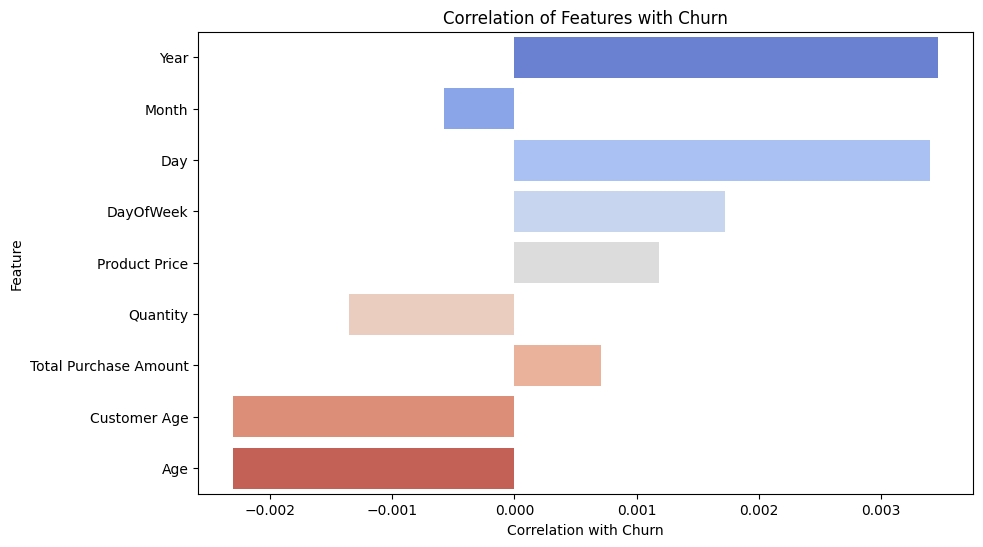

In [62]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a bar plot for the correlations
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation with Churn', y='Feature', data=correlations_df, palette='coolwarm')
plt.title('Correlation of Features with Churn')
plt.xlabel('Correlation with Churn')
plt.ylabel('Feature')
plt.show()

In [67]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

# Load the dataset
df = pd.read_csv('./archive/ecommerce_customer_data_large.csv')

# Convert 'last_purchase_date' to datetime if it exists
if 'Purchase Date' in df.columns:
    df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])
    today = datetime.today()
    df['Days Since Last Purchase'] = (today - df['Purchase Date']).dt.days
else:
    # If no date, assign a default churn period; here, we assume 180 days as a threshold.
    df['Days Since Last Purchase'] = 180

# Define a churn threshold
churn_threshold_days = 180

# Encode categorical features
categorical_columns = ["Product Category", "Payment Method", "Gender", "Returns"]
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders if needed for inverse transformation

# Calculate a basic churn risk score using categorical encodings and days since purchase
# Adjust weight for each factor as needed
df['churn_risk_score'] = (
    df['Days Since Last Purchase'] * 0.5 +  # Higher weight on time since last purchase
    df['Product Category_encoded'] * 0.2 +
    df['Payment Method_encoded'] * 0.1 +
    df['Gender_encoded'] * 0.1 +
    df['Returns_encoded'] * 0.1
)

# Determine churned status based on churn threshold score
df['churned'] = df['churn_risk_score'].apply(lambda x: 1 if x > churn_threshold_days else 0)

# Display churn status and risk score for each customer
print(df[['Customer ID', 'churned', 'churn_risk_score']])


        Customer ID  churned  churn_risk_score
0             44605        1             281.9
1             44605        1             640.7
2             44605        1             793.7
3             44605        1             334.9
4             44605        1             647.8
...             ...      ...               ...
249995        33807        1             331.7
249996        20455        1             631.1
249997        28055        1             368.6
249998        15023        1             619.6
249999         4148        1             766.2

[250000 rows x 3 columns]


In [68]:
import pandas as pd
import numpy as np

df = pd.read_csv("./archive/ecommerce_customer_data_large.csv")

df.isnull().sum()
df.fillna(0, inplace=True)

df['Purchase Date'] = pd.to_datetime(df['Purchase Date'], errors='coerce')

df['year'] = df['Purchase Date'].dt.year
df['month'] = df['Purchase Date'].dt.month
df['day'] =  df['Purchase Date'].dt.day
df['dayOfweek'] = df['Purchase Date'].dt.dayofweek
#df['date_yy_mm'] = pd.to_datetime(df['Purchase Date']).dt.strftime('%Y-%m')

df['revenue'] = df['Product Price'] * df['Quantity']

df_encoded = pd.get_dummies(df, columns=['Payment Method', 'Product Category', 'Gender'])

numeric_columns = ['Product Price', 'Quantity', 'Total Purchase Amount', 'Customer Age', 'Returns', 'Age', 'Churn', 'year', 'month' , 'dayOfweek']

numeric_columns += [col for col in df_encoded.columns if col.startswith('Payment Method_') 
                    or col.startswith('Product Category_') 
                    or col.startswith('Gender_')]

correlation_matrix = df_encoded[numeric_columns].corr()

churn_correlation = correlation_matrix['Churn'].sort_values(ascending=False)

C:\Users\burha\AppData\Local\Temp\ipykernel_12316\2899313925.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_corr_series.values, y=churn_corr_series.index, palette='coolwarm')


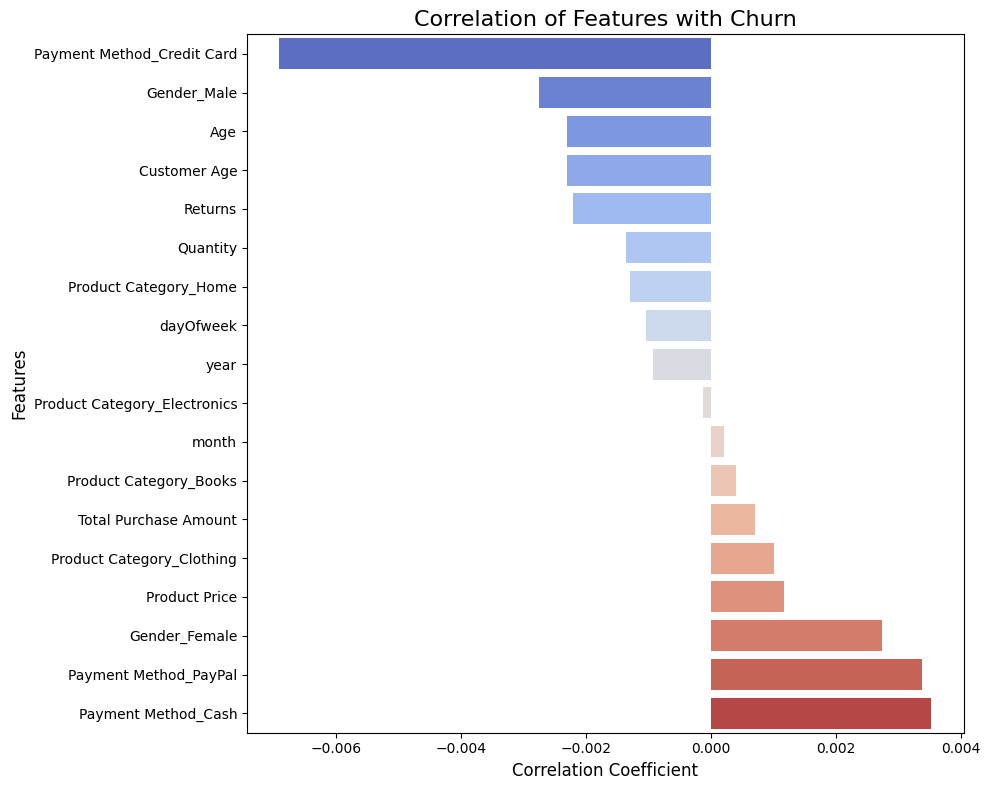

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'churn_correlation' is your correlation series
#churn_correlation = churn_correlation

# Convert the dictionary into a Pandas Series
churn_corr_series = pd.Series(churn_correlation[1:])

# Sort values to visualize better
churn_corr_series = churn_corr_series.sort_values()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Plot a horizontal barplot with Seaborn
sns.barplot(x=churn_corr_series.values, y=churn_corr_series.index, palette='coolwarm')

# Add labels and title
plt.title('Correlation of Features with Churn', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Encode categorical columns (one-hot encoding or label encoding)
df = pd.get_dummies(df, columns=["Product Category", "Payment Method", "Gender", "Returns"])

# Select features and target
features = df.drop(columns=['Customer ID', 'Last ', 'churned', 'days_since_last_purchase'])
target = df['churned']

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


KeyError: "['customer_id', 'last_purchase_date', 'churned', 'days_since_last_purchase'] not found in axis"

In [ ]:
df['churn_risk_score'] = model.predict_proba(features)[:, 1]  # Probability of churn
churn_prone_customers = df[df['churn_risk_score'] > 0.7]  # Define a threshold, e.g., 70% probability

# View high-risk customers
print(churn_prone_customers[['customer_id', 'churn_risk_score']])
